# Урок 3. Классификация. Логистическая регрессия.

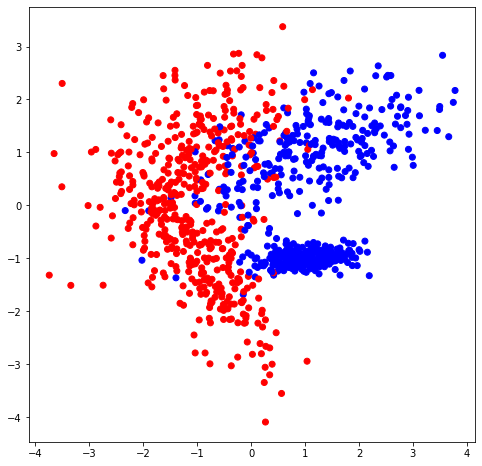

In [28]:
#1
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import datasets
from matplotlib.colors import ListedColormap
from numpy import trapz

%matplotlib inline

#генерация данных с помощью sklearn.datasets
classes = datasets.make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0,
                                     n_classes=2, random_state=110)

#графическое отображение данных
colors = ListedColormap(['red', 'blue'])

plt.figure(figsize=(8,8))
plt.scatter([x[0] for x in classes[0]], [x[1] for x in classes[0]], c=classes[1], cmap=colors)
plt.show()

In [29]:
# перемешивание датасета
np.random.seed(12)
shuffle_index = np.random.permutation(classes[0].shape[0])
X_shuffled, y_shuffled = classes[0][shuffle_index], classes[1][shuffle_index]

#разбивка на обучающую и тестовую выборки

train_proportion = 0.7
train_test_cut = int(len(classes[0]) * train_proportion)

X_train, X_test, y_train, y_test = \
    X_shuffled[:train_test_cut], \
    X_shuffled[train_test_cut:], \
    y_shuffled[:train_test_cut], \
    y_shuffled[train_test_cut:]

print('Размер массива признаков обучающей выборки', X_train.shape)
print('Размер массива признаков тестовой выборки', X_test.shape)
print('Размер массива ответов для обучающей выборки', y_train.shape)
print('Размер массива ответов для тестовой выборки', y_test.shape)

Размер массива признаков обучающей выборки (700, 2)
Размер массива признаков тестовой выборки (300, 2)
Размер массива ответов для обучающей выборки (700,)
Размер массива ответов для тестовой выборки (300,)


In [30]:
#Транспонирование матрицы данных, так как нам удобнее работать со строками

X_train_tr = X_train.transpose()
y_train_tr = y_train.reshape(1, y_train.shape[0])
X_test_tr = X_test.transpose()
y_test_tr = y_test.reshape(1, y_test.shape[0])

In [31]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [32]:
# Матрица ошибок TP, TN, FP, FN
def calc_tp_tn_fp_fn(y_act, y_pred):
    tp = sum((y_act == 1) & (y_pred == 1)) # True positive
    tn = sum((y_act == 0) & (y_pred == 0)) # True negative
    fp = sum((y_act == 0) & (y_pred == 1)) # False positive
    fn = sum((y_act == 1) & (y_pred == 0)) # False negative
    return tp, tn, fp, fn

In [33]:
# Метрики матрицы ошибок

def calc_accuracy(tp, tn, fn, fp):
    return (tp + tn) / (tp + tn + fp + fn)

def calc_precision(tp, fp):
    return tp / (tp + fp)

def calc_recall(tp, fn):
    return tp / (tp + fn)

def calc_f1_score(precision, recall):
    return 2 * precision * recall / (precision + recall)

def em_metrics(y_true, y_pred):
    tp, tn, fn, fp = calc_tp_tn_fp_fn(y_true, y_pred)
    
    table = [[tp, fp], [fn, tn]]
    print(table)
    
    accuracy = calc_accuracy(tp, tn, fn, fp)
    precision = calc_precision(tp, fp)
    recall = calc_recall(tp, fn)
    f1_score = calc_f1_score(precision, recall)
    
    print(f' Точность: {precision:.2}\n Полнота: {recall:.2}\n F1:{f1_score:.2}')
    print(f' Accuracy: {accuracy}')

In [34]:
def log_loss(w, X, y):
    m = X.shape[1]

    # используем функцию сигмоиды, написанную ранее
    A = sigmoid(np.dot(w.T, X))
    
    loss = -1.0 / m * np.sum(y * np.log(A) + (1 - y) * np.log(1 - A))
    loss = np.squeeze(loss)
    grad = 1.0 / m * np.dot(X, (A - y).T)
    
    return loss, grad

In [35]:
# Реализация градиентного спуска
def optimize(w, X, y, n_iterations, eta):
#     потери будем записывать в список для отображения в виде графика
    losses = []
    
    for i in range(n_iterations):        
        loss, grad = log_loss(w, X, y)
        w = w - eta * grad

        losses.append(loss)
        
    return w, losses

### 1.Измените функцию predict(w, X) так, чтобы можно было подать порог для классификации.

In [36]:
#Функция для выполнения предсказаний
def predict(w, X, t = 0.5):
    
    m = X.shape[1]
    
    y_predicted = np.zeros((1, m))
    w = w.reshape(X.shape[0], 1)
    
    A = sigmoid(np.dot(w.T, X))
    
    for i in range(A.shape[1]):
        if (A[:,i] > t): 
            y_predicted[:, i] = 1
        elif (A[:,i] <= t):
            y_predicted[:, i] = 0
    
    return y_predicted

### 2.Подберите аргументы функции optimize для логистической регрессии таким образом, чтобы log loss был минимальным.

In [37]:
# Инициализация начального вектора весов
w0 = np.zeros((X_train_tr.shape[0], 1))-1

n_iterations = 100
eta = 1
for eta in [0.01, 0.1, 0.5, 1, 5, 10]:
    for n_iterations in [1, 10, 100]:
        w, losses = optimize(w0, X_train_tr, y_train_tr, n_iterations, eta)
        train_accuracy = 0
        tp = 0
        for level_t in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]:
        #for level_t in [0.5]:    
            y_predicted_train = predict(w, X_train_tr, level_t)
            #калибровка
            if train_accuracy <(100.0 - np.mean(np.abs(y_predicted_train - y_train_tr)*100.0)):
                tp = level_t
    y_predicted_test = predict(w, X_test_tr, tp)
    y_predicted_train = predict(w, X_train_tr, tp)
    # в качестве меры точности выступает доля правильных ответов
    train_accuracy = 100 - np.mean(np.abs(y_predicted_train - y_train_tr)*100)
    test_accuracy = 100 - np.mean(np.abs(y_predicted_test - y_test_tr)*100)
   
    print(f'eta: {eta}')
    print(f'n_iterations: {n_iterations}')
    print(f'Итоговый вектор весов w: {w}')
    print(f'Точность на обучающей выборке: {train_accuracy:.3f}')
    print(f'Точность на тестовой выборке: {test_accuracy:.3f}')

eta: 0.01
n_iterations: 100
Итоговый вектор весов w: [[-0.30290128]
 [-0.7494971 ]]
Точность на обучающей выборке: 46.857
Точность на тестовой выборке: 52.667
eta: 0.1
n_iterations: 100
Итоговый вектор весов w: [[ 1.5725031 ]
 [-0.10789438]]
Точность на обучающей выборке: 62.143
Точность на тестовой выборке: 70.667
eta: 0.5
n_iterations: 100
Итоговый вектор весов w: [[ 2.60305029]
 [-0.03445193]]
Точность на обучающей выборке: 77.571
Точность на тестовой выборке: 82.000
eta: 1
n_iterations: 100
Итоговый вектор весов w: [[ 2.77752818]
 [-0.02925234]]
Точность на обучающей выборке: 79.286
Точность на тестовой выборке: 83.333
eta: 5
n_iterations: 100
Итоговый вектор весов w: [[ 2.81165711]
 [-0.02827429]]
Точность на обучающей выборке: 79.714
Точность на тестовой выборке: 83.333
eta: 10
n_iterations: 100
Итоговый вектор весов w: [[ 2.8116571 ]
 [-0.02827429]]
Точность на обучающей выборке: 79.714
Точность на тестовой выборке: 83.333


### 3.Посчитайте Accuracy, матрицу ошибок, точность и полноту, а также F1 score

In [38]:
def show_predict(w, X, y_predicted_train, y_train_tr):
    y_pred_log = sigmoid(np.dot(w.T, X))
    N = 50
    plt.figure(figsize=(20,5))
    plt.subplot(1,2,1)
    plt.plot(y_predicted_train[0,:N], 'r', label = 'true')
    plt.plot(y_train_tr[0,:N], '--', label = 'class predict')
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(y_predicted_train[0,:N], 'r', label = 'true')
    plt.plot(y_train_tr[0,:N], '--', label = 'log predict')
    plt.legend()
    
    plt.show()

[[230, 137], [5, 328]]
 Точность: 0.63
 Полнота: 0.98
 F1:0.76
 Accuracy: 0.7971428571428572


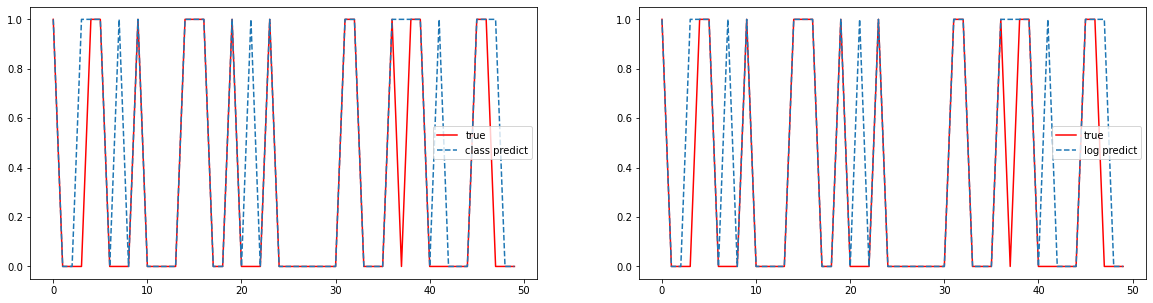

In [39]:
# Тренировочная модель
em_metrics(y_train_tr[0], y_predicted_train[0])
show_predict(w, X_train_tr, y_predicted_train, y_train_tr)

[[89, 48], [2, 161]]
 Точность: 0.65
 Полнота: 0.98
 F1:0.78
 Accuracy: 0.8333333333333334


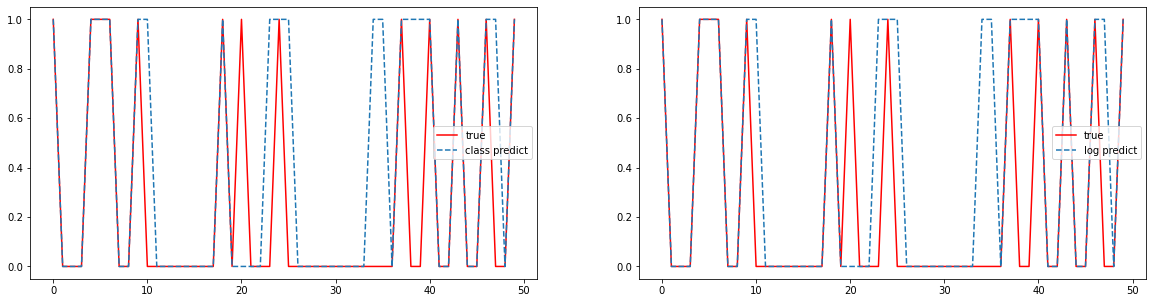

In [40]:
#Тестовая модель
em_metrics(y_test_tr[0], y_predicted_test[0])
show_predict(w, X_test_tr, y_predicted_test, y_test_tr)

Тренировочная модель
[[329, 38], [42, 291]]
 Точность: 0.9
 Полнота: 0.89
 F1:0.89
 Accuracy: 0.8857142857142857


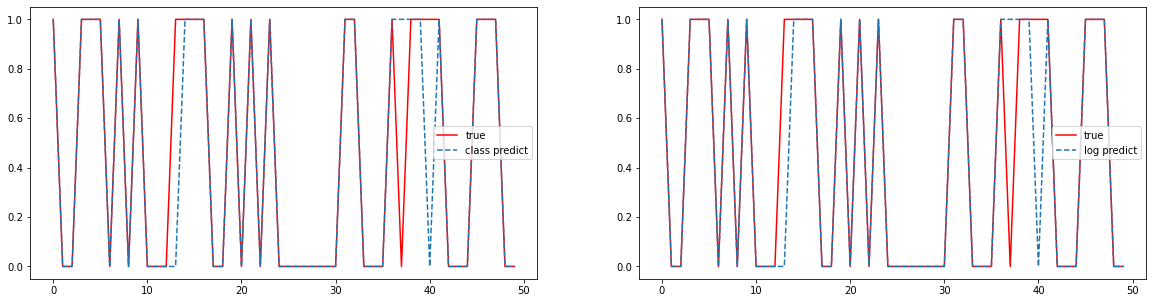

Тестовая модель
[[123, 14], [14, 149]]
 Точность: 0.9
 Полнота: 0.9
 F1:0.9
 Accuracy: 0.9066666666666666


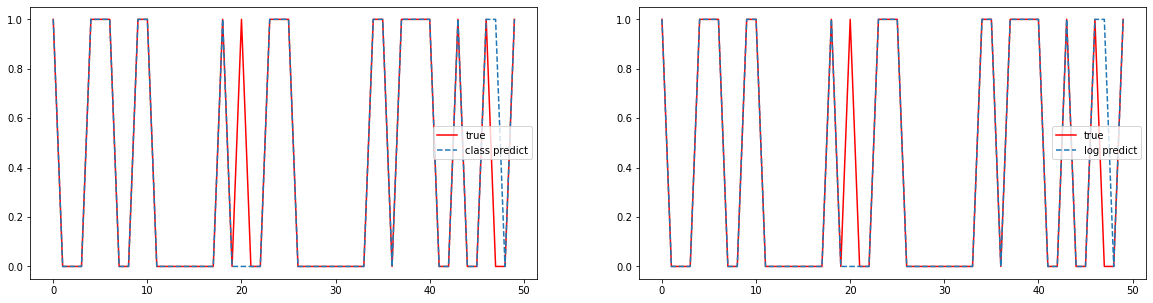

In [41]:
# Определение влияния порога на метрики
y_predicted_test = predict(w, X_test_tr, 0.5)
y_predicted_train = predict(w, X_train_tr, 0.5)
print('Тренировочная модель')
em_metrics(y_train_tr[0], y_predicted_train[0])
show_predict(w, X_train_tr, y_predicted_train, y_train_tr)
print('Тестовая модель')
em_metrics(y_test_tr[0], y_predicted_test[0])
show_predict(w, X_test_tr, y_predicted_test, y_test_tr)

Тренировочная модель
[[309, 58], [18, 315]]
 Точность: 0.84
 Полнота: 0.94
 F1:0.89
 Accuracy: 0.8914285714285715


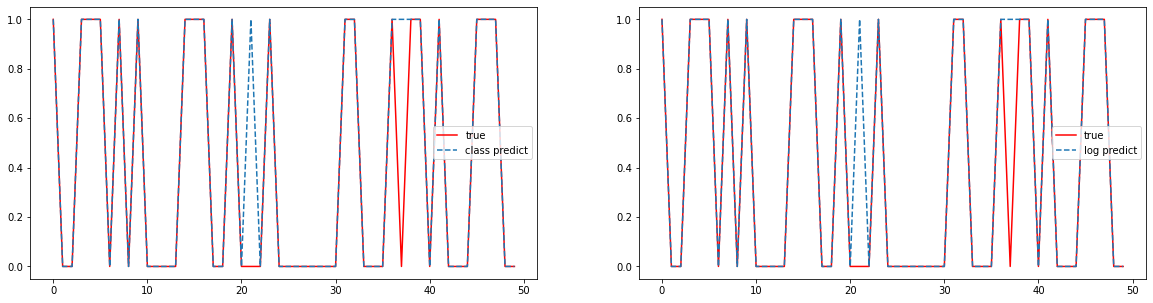

Тестовая модель
[[114, 23], [9, 154]]
 Точность: 0.83
 Полнота: 0.93
 F1:0.88
 Accuracy: 0.8933333333333333


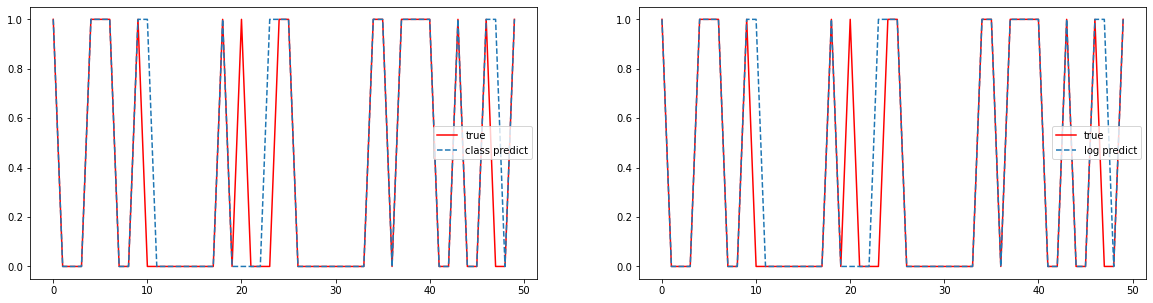

In [42]:
# Определение влияния порога на метрики
y_predicted_test = predict(w, X_test_tr, 0.7)
y_predicted_train = predict(w, X_train_tr, 0.7)
print('Тренировочная модель')
em_metrics(y_train_tr[0], y_predicted_train[0])
show_predict(w, X_train_tr, y_predicted_train, y_train_tr)
print('Тестовая модель')
em_metrics(y_test_tr[0], y_predicted_test[0])
show_predict(w, X_test_tr, y_predicted_test, y_test_tr)

Тренировочная модель
[[285, 82], [9, 324]]
 Точность: 0.78
 Полнота: 0.97
 F1:0.86
 Accuracy: 0.87


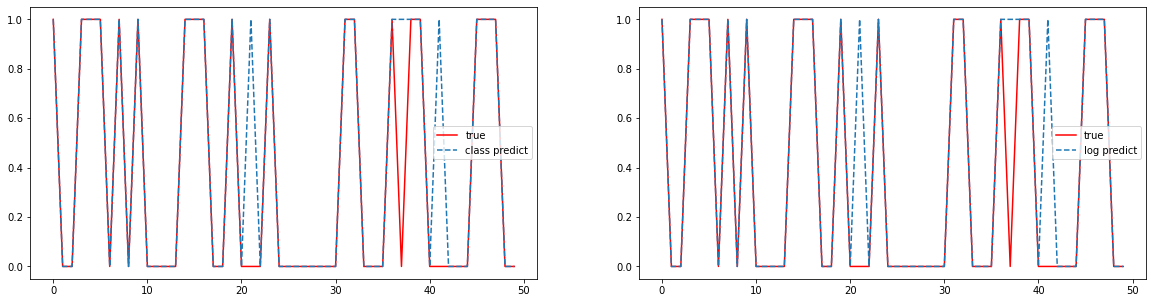

Тестовая модель
[[108, 29], [4, 159]]
 Точность: 0.79
 Полнота: 0.96
 F1:0.87
 Accuracy: 0.89


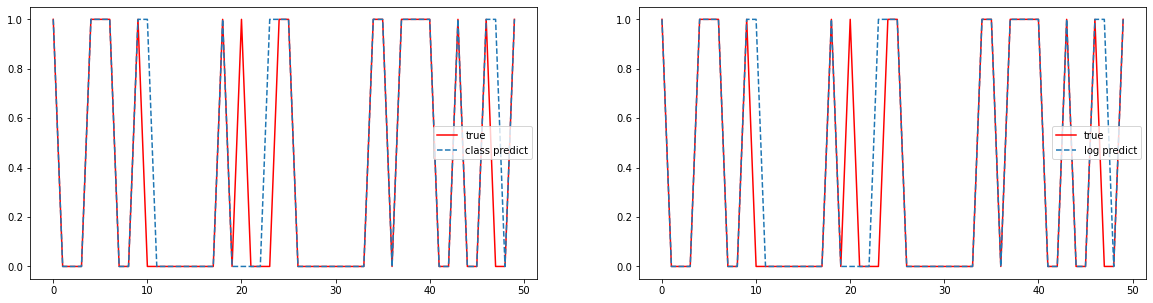

In [43]:
# Определение влияния порога на метрики
y_predicted_test = predict(w, X_test_tr, 0.8)
y_predicted_train = predict(w, X_train_tr, 0.8)
print('Тренировочная модель')
em_metrics(y_train_tr[0], y_predicted_train[0])
show_predict(w, X_train_tr, y_predicted_train, y_train_tr)
print('Тестовая модель')
em_metrics(y_test_tr[0], y_predicted_test[0])
show_predict(w, X_test_tr, y_predicted_test, y_test_tr)

### 4.Постройте кривую обучения

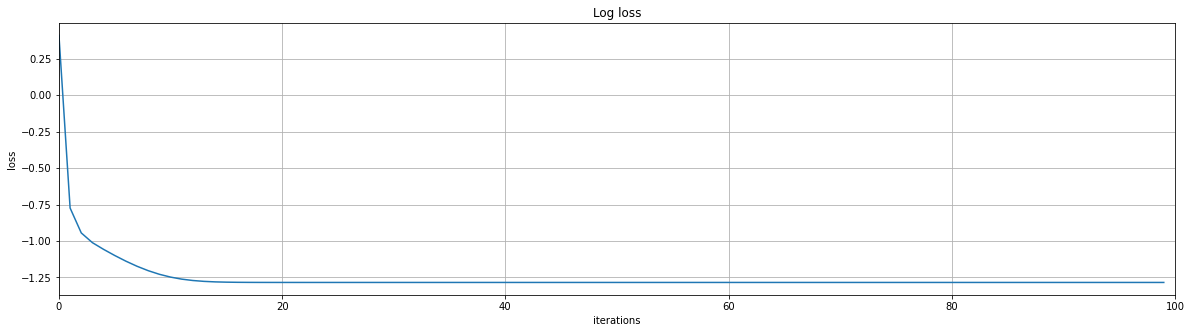

In [44]:
plt.figure(figsize=(20,5))
plt.title('Log loss')
plt.xlim(0, 100)
plt.xlabel('iterations')
plt.ylabel('loss')
plt.plot(range(len(losses)), np.log(losses))
plt.grid(True)

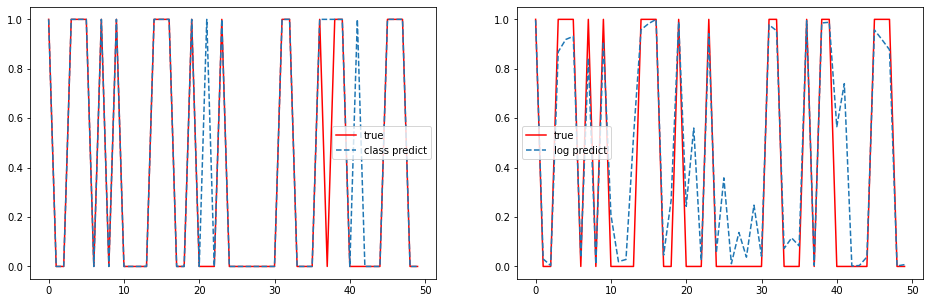

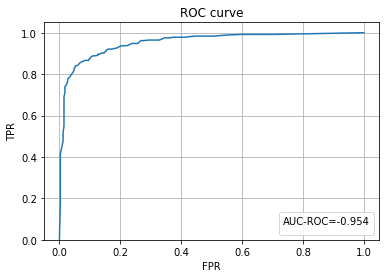

In [45]:
import pandas as pd

y_pred_log = sigmoid(np.dot(w.T,  X_train_tr))
N = 50
plt.figure(figsize = (16,5))
plt.subplot(1,2,1)
plt.plot(y_predicted_train[0,:N],'r', label = 'true')
plt.plot(y_train_tr[0,:N],'--', label = 'class predict')
plt.legend()

plt.subplot(1,2,2)
plt.plot(y_predicted_train[0,:N],'r', label = 'true')
plt.plot(y_pred_log[0,:N],'--',label = 'log predict')
plt.legend()

plt.show()
y  = pd.DataFrame(y_pred_log[0,:])
y[1]=y_train_tr[0,:]


TPR = []
FPR = []
mm = np.linspace(0,1,100).tolist()
for i in mm:#arange(len(y.iloc[:,0])):
    tresholds = i#y.iloc[i,0]-0.00000000001
    y_p = y.iloc[:,0]>tresholds
    c = [[np.sum((y.iloc[:,1] ==1)&(y_p == y.iloc[:,1])), np.sum((y.iloc[:,1] ==1)&(y_p != y.iloc[:,1]) ) ],
         [np.sum((y.iloc[:,1] ==0)&(y_p != y.iloc[:,1]) ), np.sum((y.iloc[:,1] ==0)&(y_p == y.iloc[:,1])) ]]
    TP = c[0][0]
    TN = c[1][1]
    FP = c[1][0]
    FN = c[0][1]
    
    TPR.append(TP/(TP+FN))
    FPR.append(FP/(FP+TN))
    


AUC_ROC = trapz(TPR, x = FPR, dx=0.1)

plt.title('ROC curve')
plt.ylim(0, 1.05)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.grid()
plt.legend(' ', title=f'AUC-ROC={AUC_ROC:.3f}', loc='lower right')
plt.plot(FPR, TPR)
plt.show()

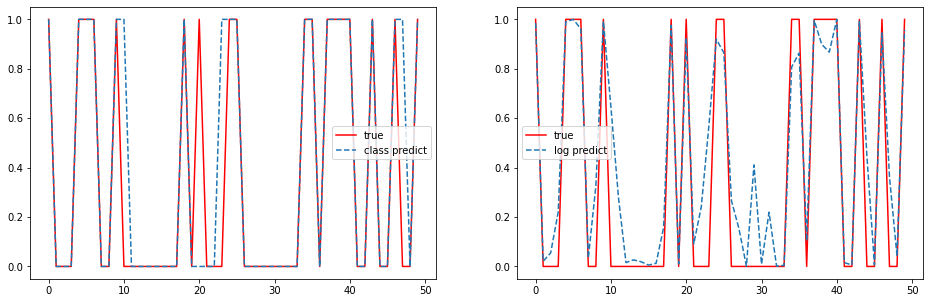

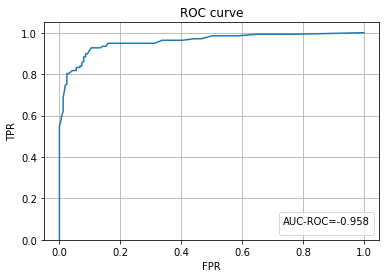

In [46]:
import pandas as pd

y_pred_log = sigmoid(np.dot(w.T,  X_test_tr))
N = 50
plt.figure(figsize = (16,5))
plt.subplot(1,2,1)
plt.plot(y_predicted_test[0,:N],'r', label = 'true')
plt.plot(y_test_tr[0,:N],'--', label = 'class predict')
plt.legend()

plt.subplot(1,2,2)
plt.plot(y_predicted_test[0,:N],'r', label = 'true')
plt.plot(y_pred_log[0,:N],'--',label = 'log predict')
plt.legend()

plt.show()
y  = pd.DataFrame(y_pred_log[0,:])
y[1]=y_test_tr[0,:]


TPR = []
FPR = []
mm = np.linspace(0,1,100).tolist()
for i in mm:#arange(len(y.iloc[:,0])):
    tresholds = i#y.iloc[i,0]-0.00000000001
    y_p = y.iloc[:,0]>tresholds
    c = [[np.sum((y.iloc[:,1] ==1)&(y_p == y.iloc[:,1])), np.sum((y.iloc[:,1] ==1)&(y_p != y.iloc[:,1]) ) ],
         [np.sum((y.iloc[:,1] ==0)&(y_p != y.iloc[:,1]) ), np.sum((y.iloc[:,1] ==0)&(y_p == y.iloc[:,1])) ]]
    TP = c[0][0]
    TN = c[1][1]
    FP = c[1][0]
    FN = c[0][1]
    
    TPR.append(TP/(TP+FN))
    FPR.append(FP/(FP+TN))
    


AUC_ROC = trapz(TPR, x = FPR, dx=0.1)

plt.title('ROC curve')
plt.ylim(0, 1.05)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.grid()
plt.legend(' ', title=f'AUC-ROC={AUC_ROC:.3f}', loc='lower right')
plt.plot(FPR, TPR)
plt.show()

In [47]:
def get_precision_recall (y_true, y_pred):
    
    tp, tn, fp, fn = calc_tp_tn_fp_fn(y_true, y_pred)
    
    presision = calc_precision(tp, fp)
    recall = calc_recall(tp, fn)
    
    return presision, recall

In [48]:
def show_PR(w, X, Y_true):
    
    presision = []
    recall = []

    for i in np.linspace(0,1,100).tolist():
        y_predicted_test = predict(w, X, i)
        prec, rec = get_precision_recall(Y_true[0], y_predicted_test[0])
        presision.append(prec)
        recall.append(rec)
        
    AUC_PR = trapz(presision, x = recall, dx=0.1)
    
    plt.title('PR curve')
    plt.ylim(0, 1.05)
    plt.xlabel('recall')
    plt.ylabel('presision')
    plt.grid()
    plt.legend(' ', title=f'AUC_PR={AUC_PR:.3f}', loc='lower right')
    plt.plot(recall, presision)
    plt.show()

<ipython-input-33-7fe594939e16>:7: RuntimeWarning: invalid value encountered in long_scalars
  return tp / (tp + fp)


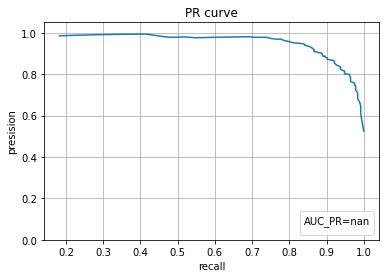

In [49]:
# (29) отображение тренировочной выборки
show_PR(w, X_train_tr, y_train_tr)

<ipython-input-33-7fe594939e16>:7: RuntimeWarning: invalid value encountered in long_scalars
  return tp / (tp + fp)


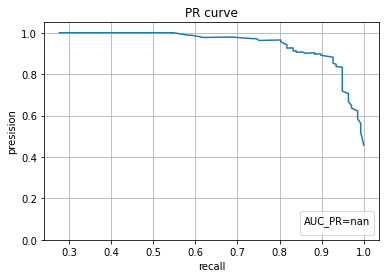

In [50]:
# (30) отображение тестовойой выборки
show_PR(w, X_test_tr, y_test_tr)

### 5.Оцените результаты и сделайте выводы.

При увеличении значения порога,  - увеличивается точность, уменьшается полнота.

### 6.Попробуйте ответить на вопросы: Могла ли модель переобучиться? На каком шаге это произошло? Почему?

Значения метри тестовой и тренирововчнйо модели близки. Переобучиться не могла, скорее речь может идти о недостаточности размера датасета.